In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
cuda = torch.cuda.is_available()
import numpy as np
import collections
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from skimage import io


In [2]:
import torchvision
from PIL import Image

#981
train_size= 589
val_size= 196
test_size = 196

In [3]:
def parse_data(datadir, label_map):
    img_list = []
    file_list = []
    
    for root, directories, filenames in os.walk(datadir):      
        for filename in filenames:
            file_list.append(filename)
            if filename.endswith('.png'):
                
                filei = os.path.join(root, filename)
                file_ids = filename.split('_')
                file_id = file_ids[0] + '_' + file_ids[1]
                if file_id in label_map:
                    img_list.append(filei)
    return img_list[:train_size], img_list[train_size:train_size+val_size], img_list[train_size+val_size: train_size+val_size+test_size]
#     return img_list



def parse_emotion_data(datadir):
    em_map = {}
    file_list = []
    for root, directories, filenames in os.walk(datadir):
        for filename in filenames:
            file_list.append(filename)
            if filename.endswith('.txt'):
                   
                f = open(root +  "/" + filename, 'r')
                lines = []
                for line in f.readlines():
                    lines.append(line)
                value = lines[0]
                f.close()
                
                keys = filename.split('_')
                key = keys[0] + '_' + keys[1]
                em_map[key] = int(float(value.strip())) - 1
                
    return em_map


def split_folds_data(data, fold_id, num_folds):
    fold_size = len(data)//num_folds
    print(fold_size)
    data = data[:fold_size * num_folds]

    
    val_fold_ids = [(fold_id) % num_folds, (fold_id + 1) % num_folds]
    test_fold_ids = [(fold_id + 2) % num_folds, (fold_id + 3) % num_folds]
    
    data_div = [data[i*fold_size : (i+1)*fold_size] for i in range(num_folds)]
    
    t_data = np.concatenate([data_div[i] for i in range(num_folds) if i not in val_fold_ids and i not in test_fold_ids], axis=0)
    
    v_data = np.concatenate([data_div[fid] for fid in val_fold_ids], axis = 0)
    
    test_data = np.concatenate([data_div[fid] for fid in test_fold_ids], axis = 0)
    return t_data, v_data, test_data


In [4]:
label_map = parse_emotion_data("Emotion")
# img_list = parse_data("cohn-kanade-images", label_map)


# for i in range(10):
#     t_data, v_data, test_data = split_folds_data(img_list, i, 10)
#     print("img_list", len(img_list))
#     print("t_data len", len(t_data))
#     print("v_data len", len(v_data))
#     print("test_data len", len(test_data))
#     print("\n");
    

#     assert 0.6 * (len(img_list) - 1) == len(t_data)
#     assert 0.2 * (len(img_list) - 1) == len(v_data)
#     assert 0.2 * (len(img_list) - 1) == len(test_data)


In [5]:
class ImageDataset(Dataset):
    def __init__(self, file_list, label_map, train = False):
        self.file_list = file_list
        self.label_map = label_map
        self.train = train
        self.data_len = len(self.file_list)

    def __len__(self):
        if self.train:
            return self.data_len * 5
        else:
            return self.data_len

    def __getitem__(self, index):
        img = None
        img_pil = None
        img_h = 224
        img_w = 224
        if index < self.data_len:
            img = Image.open(self.file_list[index])
            img_pil = torchvision.transforms.Resize((img_h,img_w))(img)
            img = torchvision.transforms.ToTensor()(img_pil)
        elif index < 2 * self.data_len:
            index = index - self.data_len
            img = Image.open(self.file_list[index])
            img = torchvision.transforms.RandomHorizontalFlip(p = 1.0)(img)
            img_pil = torchvision.transforms.Resize((img_h,img_w))(img)
            img = torchvision.transforms.ToTensor()(img_pil)
        elif index < 3 * self.data_len:
            index = index - 2 * self.data_len
            img = Image.open(self.file_list[index])
            img = torchvision.transforms.RandomRotation(30)(img)
            img_pil = torchvision.transforms.Resize((img_h,img_w))(img)
            img = torchvision.transforms.ToTensor()(img_pil)
        elif index < 4 * self.data_len:
            index = index - 3 * self.data_len
            img = Image.open(self.file_list[index])
            img = torchvision.transforms.RandomAffine(5, translate=(0.1,0.1), scale=(1.1,1.2), shear=0, resample=False, fillcolor=0)(img)
            img_pil = torchvision.transforms.Resize((img_h,img_w))(img)
            img = torchvision.transforms.ToTensor()(img_pil)
        else:
            index = index - 4 * self.data_len
            img = Image.open(self.file_list[index])
            img = torchvision.transforms.RandomAffine(5, translate=(0,0), scale=(1.1,1.2), shear=5, resample=False, fillcolor=0)(img)
            img_pil = torchvision.transforms.Resize((img_h,img_w))(img)
            img = torchvision.transforms.ToTensor()(img_pil)
            
            
        
        if img.shape[0] == 3:
            img = torchvision.transforms.Grayscale(num_output_channels=1)(img_pil)
            img = torchvision.transforms.ToTensor()(img)
        img = torchvision.transforms.Normalize(mean=[0.485], std=[0.229])(img)
        keys = self.file_list[index].split('/')[-1].split('.')[0].split('_')
        label = self.label_map[keys[0] + '_' + keys[1]]
        return img, label

In [6]:
def dataset_hist_data(dataset):
    dataiter = iter(dataset)
    labels = []
    for i in range(len(dataset)):
        _, label = dataiter.next()
        labels += [label]
    return labels


# labels_all = [dataset_hist_data(train_dataset), dataset_hist_data(dev_dataset), dataset_hist_data(test_dataset)]
# n_bins = 30
# colors = ['red', 'tan', 'lime']
# plt.hist(labels_all, n_bins, density=True, histtype='bar', color=colors, label=['train', 'dev', 'test'])
# plt.legend(prop={'size': 10})
# plt.title("Data distribution")
# plt.show()





In [7]:
# Given image filename, return it's corresponding label from label_map
def label_util(filename, label_map):
    keys = filename.split('/')[-1].split('.')[0].split('_')
    label = label_map[keys[0] + '_' + keys[1]]
    return label

# expressions = ['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise']
# idxs = np.random.randint(100, size=8)
# f, a = plt.subplots(2, 4, figsize=(10, 5))

    
# for i in range(8):
#     image = io.imread(train_img_list[idxs[i]]) 
#     r, c = i // 4, i % 4
    
#     # Display an image
#     label_no = label_util(train_img_list[idxs[i]], label_map)
#     a[r][c].set_title(expressions[label_no])
#     a[r][c].imshow(image)
#     a[r][c].axis('off')

# plt.show()

In [8]:
import logging
logging.basicConfig(filename="training_baseline.log" ,
                            filemode="a+")
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [9]:
# train_dataset, dev_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, val_size, test_size))

In [10]:
# for i in range(len(train_dataset)):
#     print(train_dataset[i][0].shape)

In [11]:
class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
                          nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=kernel_size, stride=stride),
                          nn.ReLU(),
                          nn.MaxPool2d(2))
        
    def forward(self, x):
        return self.block(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BaselineModel(nn.Module):
    def __init__(self, num_blocks):
        super(BaselineModel, self).__init__()
        layers = []
        num_classes = 7
        channels = [1, 64, 128, 256] # this needs to be modified according to num_blocks
        
        for i in range(num_blocks):
            layers.append(ConvBlock(C_in=channels[i], C_out=channels[i+1], kernel_size=5, stride=1))
        
        layers.append(nn.Dropout(p=0.25))
        
        layers.append(Flatten())
        
        layers.append(nn.Linear(256*24*24, 512))
        
        layers.append(nn.Dropout(p=0.5))
        
        layers.append(nn.Linear(512, num_classes))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [12]:
model = BaselineModel(num_blocks=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
print(model)

BaselineModel(
  (net): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): Dropout(p=0.25, inplace=False)
    (4): Flatten()
    (5): Linear(in_features=147456, out_features=512, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=7, bias=True)
  )
)


In [13]:
def train(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels.long())
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_loss(model,train_dataloader)
        test_loss, test_accuracy = test_classify_loss(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_loss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [ ]:
num_folds = 1
batch_size = 32
running_val_acc = 0.0
running_test_acc = 0.0

for fold_id in range(0, num_folds):
    
#     train_img_list, val_img_list, test_list = split_folds_data(img_list, fold_id, num_folds)

    train_img_list, val_img_list, test_img_list = parse_data("cohn-kanade-images", label_map)
    train_dataset = ImageDataset(train_img_list, label_map, True)
    dev_dataset = ImageDataset(val_img_list, label_map)
    test_dataset = ImageDataset(test_img_list, label_map)

    # dataset based on fold_id
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=8)

    dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=8)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                               shuffle=True, num_workers=8)

    train_losses, eval_losses, eval_accs = train(model,100, train_dataloader,dev_dataloader)
    running_val_acc += eval_accs[-1]
    
    test_loss, test_acc = test_classify_loss(model, test_dataloader)
    running_test_acc += test_acc[-1]
    
    
final_val_acc = running_val_acc / num_folds
final_test_acc = running_test_acc / num_folds

print("val acc | test acc  ", final_val_acc, final_test_acc)

In [ ]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.savefig("training_loss.png")

In [ ]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('accuracy')
plt.plot(eval_accs)
plt.savefig("val_acc.png")

In [18]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, 
                                               shuffle=False, num_workers=8)

In [19]:
test_loss, test_accuracy = test_classify_loss(model, test_data_loader)

In [20]:
test_loss, test_accuracy

(1.1186939684712156, 0.6377551020408163)

In [67]:
conv1 = model.net[:1] #1st Conv Layer
conv3 = model.net[:2] #1st 3 Conv Layer

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show(img):
    img = img.to("cpu")
    npimg = img.numpy()
    plt.figure(figsize=(12,12))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

input:  torch.Size([32, 1, 224, 224]) output:  torch.Size([32, 64, 110, 110])


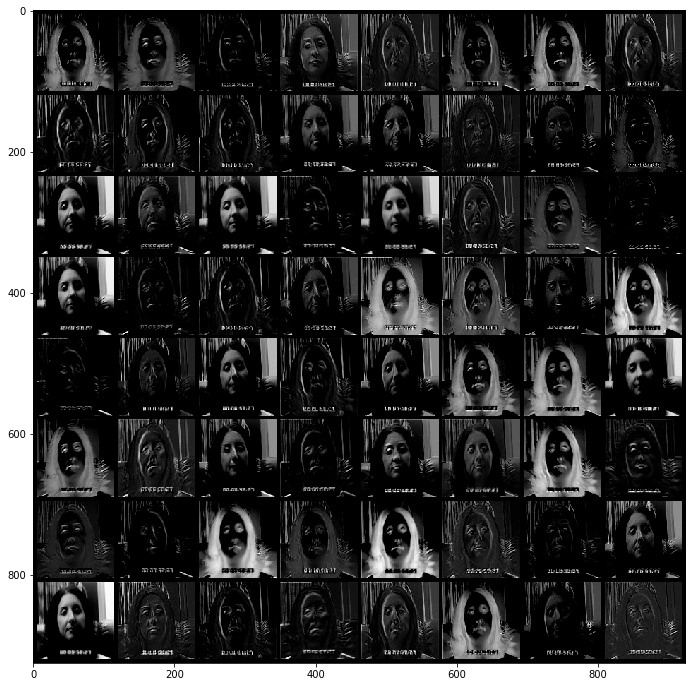

In [69]:
for x, y in test_data_loader:
    x = x.to(device)
    y = y.to(device)
    out = conv1(x)
    print('input: ', x.shape, 'output: ', out.shape)
    show(make_grid(out[0].data.unsqueeze(1), nrow=8, scale_each=True, normalize=True, padding=5))
    break

input:  torch.Size([32, 1, 224, 224]) output:  torch.Size([32, 128, 53, 53])


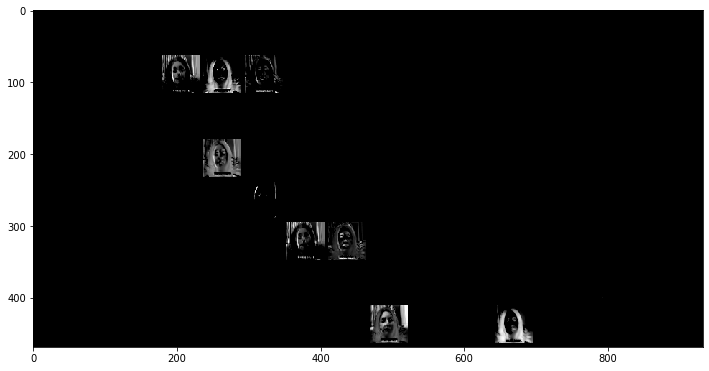

In [73]:
for x, y in test_data_loader:
    x = x.to(device)
    y = y.to(device)
    out = conv3(x)
    print('input: ', x.shape, 'output: ', out.shape)
    show(make_grid(out[0].data.unsqueeze(1), nrow=16, scale_each=True, normalize=True, padding=5))
    break